# Spot check training and testing on single example

In [52]:
import json
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from shap import DeepExplainer
from sklearn.model_selection import KFold

sys.path.insert(0, "/mnt/c/Users/nick/Desktop/corsello_lab/refract")
import argparse
import logging

from refract.datasets import PrismDataset
from refract.losses import lambdaLoss
from refract.metrics import get_stringdb_network_interactions
from refract.models import FeedForwardNet
from refract.ranking_trainers import NNRankerTrainer

from scipy.stats import pearsonr

In [ ]:
# basic command
# python runXGBoostRankingTrain.py --response_path /mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230607_validate_performance/FINAL_updated_responses/caramiphen.csv --feature_path /mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_public-22q1-305b_v24/x-all.pkl --feature_importance_path /mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230607_validate_performance/feature_importance_paths/caramiphen.csv --output_dir /mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230608_revisit_xgboost.ipynb/output/caramiphen

In [53]:
logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")

NUM_FEATURES = 100
SLATE_LENGTH = 10
NUM_EPOCHS = 50
BATCH_SIZE = 512

In [54]:
compound_name = "caramiphen"

In [55]:
response_path = f"/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230607_validate_performance/FINAL_updated_responses/{compound_name}.csv"
feature_importance_path = f"/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230607_validate_performance/feature_importance_paths/{compound_name}.csv"
feature_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_public-22q1-305b_v24/x-all.pkl"

In [56]:
output_dir = os.path.join("output_dir", compound_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [57]:
# load data
logger.info("Loading feature data...")
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
feature_df = feature_df.rename_axis("ccle_name")

logger.info("Loading response data...")
response_df = pd.read_csv(response_path)
feature_importance_df = pd.read_csv(feature_importance_path)


INFO:__main__:Loading feature data...
INFO:__main__:Loading response data...


In [58]:
feature_df.head()

,GE_TSPAN6,GE_TNMD,GE_DPM1,GE_SCYL3,GE_C1orf112,GE_FGR,GE_CFH,GE_FUCA2,GE_GCLC,GE_NFYA,...,LIN_upper_aerodigestive,LIN_upper_aerodigestive_carcinoma,LIN_upper_aerodigestive_squamous,LIN_urinary_tract,LIN_uterine_carcinosarcoma,LIN_uterine_sarcoma,LIN_uterus,LIN_uveal_melanoma,LIN_WD_DDPLS,LIN_WDLPS
ccle_name,,,,,,,,,,,,,,,,,,,,,
LC1SQSF_LUNG,4.990501,0.000000,7.273702,2.765535,4.480265,0.028569,1.269033,3.058316,6.483171,5.053980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COGAR359_SOFT_TISSUE,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,3.832890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KKU213_BILIARY_TRACT,5.726831,0.000000,7.086189,2.543496,3.102658,0.000000,5.914565,6.099716,4.475733,4.294253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RT4_URINARY_TRACT,7.465648,0.000000,6.435462,2.414136,3.864929,0.831877,7.198003,5.452530,7.112492,4.710944,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
DEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.097611,0.000000,5.919102,3.983678,3.733354,0.028569,6.111240,2.963474,3.415488,4.820690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# TEST: permute the labels on feature_df
"""
ccle_name = feature_df.index.values
# randomize ccle_name order
np.random.shuffle(ccle_name)
feature_df.index = ccle_name
# name index
feature_df.index.name = "ccle_name"
"""

'\nccle_name = feature_df.index.values\n# randomize ccle_name order\nnp.random.shuffle(ccle_name)\nfeature_df.index = ccle_name\n# name index\nfeature_df.index.name = "ccle_name"\n'

In [60]:
feature_df.head()

,GE_TSPAN6,GE_TNMD,GE_DPM1,GE_SCYL3,GE_C1orf112,GE_FGR,GE_CFH,GE_FUCA2,GE_GCLC,GE_NFYA,...,LIN_upper_aerodigestive,LIN_upper_aerodigestive_carcinoma,LIN_upper_aerodigestive_squamous,LIN_urinary_tract,LIN_uterine_carcinosarcoma,LIN_uterine_sarcoma,LIN_uterus,LIN_uveal_melanoma,LIN_WD_DDPLS,LIN_WDLPS
ccle_name,,,,,,,,,,,,,,,,,,,,,
LC1SQSF_LUNG,4.990501,0.000000,7.273702,2.765535,4.480265,0.028569,1.269033,3.058316,6.483171,5.053980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COGAR359_SOFT_TISSUE,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,3.832890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KKU213_BILIARY_TRACT,5.726831,0.000000,7.086189,2.543496,3.102658,0.000000,5.914565,6.099716,4.475733,4.294253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RT4_URINARY_TRACT,7.465648,0.000000,6.435462,2.414136,3.864929,0.831877,7.198003,5.452530,7.112492,4.710944,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
DEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.097611,0.000000,5.919102,3.983678,3.733354,0.028569,6.111240,2.963474,3.415488,4.820690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)

In [62]:
for i, (train_index, test_index) in enumerate(splitter.split(response_df)):
    response_train = response_df.iloc[train_index, :].copy()
    response_test = response_df.iloc[test_index, :].copy()

In [63]:
len(response_train)

432

In [64]:
len(response_test)

108

In [65]:
# verify train contains no test samples
print(len(set(response_train["ccle_name"]).intersection(set(response_test["ccle_name"]))))

0


In [66]:
response_train.head()

,LFC.cb,ccle_name,pert_name,pert_idose,pert_mfc_id,culture,pert_dose_unit
0,0.184908,NIHOVCAR3_OVARY,caramiphen,2.591975,BRD-K59895502-001-01-9,fake_culture,uM
2,-0.056332,A101D_SKIN,caramiphen,2.591975,BRD-K59895502-001-01-9,fake_culture,uM
3,-0.031703,253J_URINARY_TRACT,caramiphen,2.591975,BRD-K59895502-001-01-9,fake_culture,uM
4,0.418922,HCC827_LUNG,caramiphen,2.591975,BRD-K59895502-001-01-9,fake_culture,uM
5,-0.459647,ONCODG1_OVARY,caramiphen,2.591975,BRD-K59895502-001-01-9,fake_culture,uM


In [67]:
response_train.ccle_name

0         NIHOVCAR3_OVARY
2              A101D_SKIN
3      253J_URINARY_TRACT
4             HCC827_LUNG
5           ONCODG1_OVARY
              ...        
533    TTC549_SOFT_TISSUE
535           WM2664_SKIN
536         8305C_THYROID
538         PLCPRF5_LIVER
539            TT_THYROID
Name: ccle_name, Length: 432, dtype: object

In [68]:
# split up the feature df into train and test
feature_train = feature_df.loc[feature_df.index.isin(response_train.ccle_name.values), :].copy()
feature_test = feature_df.loc[feature_df.index.isin(response_test.ccle_name.values), :].copy()

In [69]:
print(len(feature_train))
print(len(feature_test))

431
108


In [70]:
# Train the model 
ds_train = PrismDataset(
    response_train,
    feature_train,
    feature_importance_df,
    top_k_features=NUM_FEATURES,
    slate_length=SLATE_LENGTH
)

ds_test = PrismDataset(
    response_test,
    feature_test,
    feature_importance_df,
    top_k_features=NUM_FEATURES,
    slate_length=SLATE_LENGTH
)

In [71]:
model = FeedForwardNet(NUM_FEATURES)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = NNRankerTrainer(model, optimizer)

In [72]:
trainer.train(ds_train, BATCH_SIZE, NUM_EPOCHS)

INFO:refract.ranking_trainers:Epoch: 0, Loss: 552.595947265625
INFO:refract.ranking_trainers:Epoch: 1, Loss: 577.520751953125
INFO:refract.ranking_trainers:Epoch: 2, Loss: 594.9465942382812
INFO:refract.ranking_trainers:Epoch: 3, Loss: 607.0777587890625
INFO:refract.ranking_trainers:Epoch: 4, Loss: 588.50634765625
INFO:refract.ranking_trainers:Epoch: 5, Loss: 582.31689453125
INFO:refract.ranking_trainers:Epoch: 6, Loss: 577.937255859375
INFO:refract.ranking_trainers:Epoch: 7, Loss: 570.5594482421875
INFO:refract.ranking_trainers:Epoch: 8, Loss: 547.9864501953125
INFO:refract.ranking_trainers:Epoch: 9, Loss: 550.3007202148438
INFO:refract.ranking_trainers:Epoch: 10, Loss: 532.3049926757812
INFO:refract.ranking_trainers:Epoch: 11, Loss: 510.77264404296875
INFO:refract.ranking_trainers:Epoch: 12, Loss: 501.2484130859375
INFO:refract.ranking_trainers:Epoch: 13, Loss: 493.115478515625
INFO:refract.ranking_trainers:Epoch: 14, Loss: 480.80120849609375
INFO:refract.ranking_trainers:Epoch: 15, 

In [73]:
# manually evaluate
train_ccle_names, train_preds, train_trues, train_corr = trainer.eval(ds_train)
test_ccle_names, test_preds, test_trues, test_corr = trainer.eval(ds_test)


In [74]:
print("R train: ", train_corr)
print("R test: ", test_corr)

R train:  (0.5966055025708594, 6.651732968991848e-43)
R test:  (0.4455555674393738, 1.3511932878738773e-06)


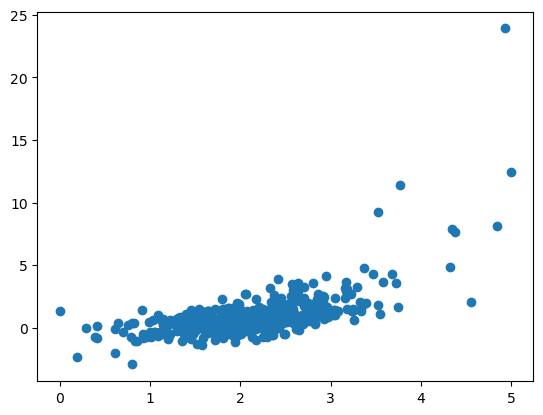

In [21]:
import matplotlib.pyplot as plt
plt.scatter(train_trues, train_preds)

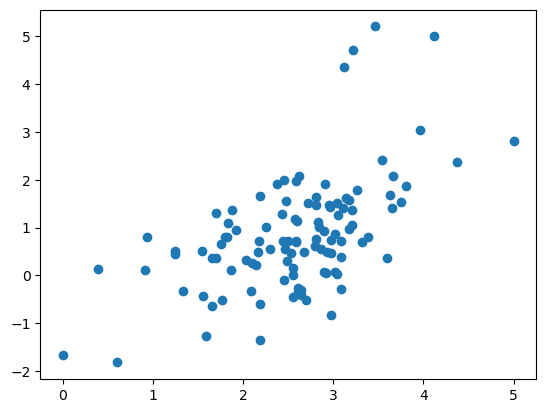

In [22]:
plt.scatter(test_trues, test_preds)